In [4]:
import numpy as np

In [1]:
import numpy as np
import tensorflow as tf # pylint: ignore-module
import builtins
import functools
import copy
import os

# =====================a===========================================
# Import all names into common namespace
# ================================================================

clip = tf.clip_by_value

# Make consistent with numpy
# ----------------------------------------

def sum(x, axis=None, keepdims=False):
    return tf.reduce_sum(x, reduction_indices=None if axis is None else [axis], keep_dims = keepdims)
def mean(x, axis=None, keepdims=False):
    return tf.reduce_mean(x, reduction_indices=None if axis is None else [axis], keep_dims = keepdims)
def var(x, axis=None, keepdims=False):
    meanx = mean(x, axis=axis, keepdims=keepdims)
    return mean(tf.square(x - meanx), axis=axis, keepdims=keepdims)
def std(x, axis=None, keepdims=False):
    return tf.sqrt(var(x, axis=axis, keepdims=keepdims))
def max(x, axis=None, keepdims=False):
    return tf.reduce_max(x, reduction_indices=None if axis is None else [axis], keep_dims = keepdims)
def min(x, axis=None, keepdims=False):
    return tf.reduce_min(x, reduction_indices=None if axis is None else [axis], keep_dims = keepdims)
def concatenate(arrs, axis=0):
    return tf.concat(axis, arrs)
def argmax(x, axis=None):
    return tf.argmax(x, dimension=axis)

def switch(condition, then_expression, else_expression):
    '''Switches between two operations depending on a scalar value (int or bool).
    Note that both `then_expression` and `else_expression`
    should be symbolic tensors of the *same shape*.

    # Arguments
        condition: scalar tensor.
        then_expression: TensorFlow operation.
        else_expression: TensorFlow operation.
    '''
    x_shape = copy.copy(then_expression.get_shape())
    x = tf.cond(tf.cast(condition, 'bool'),
                lambda: then_expression,
                lambda: else_expression)
    x.set_shape(x_shape)
    return x

# Extras
# ----------------------------------------
def l2loss(params):
    if len(params) == 0:
        return tf.constant(0.0)
    else:
        return tf.add_n([sum(tf.square(p)) for p in params])
def lrelu(x, leak=0.2):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * x + f2 * abs(x)
def categorical_sample_logits(X):
    # https://github.com/tensorflow/tensorflow/issues/456
    U = tf.random_uniform(tf.shape(X))
    return argmax(X - tf.log(-tf.log(U)), axis=1)

# ================================================================
# Global session
# ================================================================

def get_session():
    return tf.get_default_session()

def single_threaded_session():
    tf_config = tf.ConfigProto(
        inter_op_parallelism_threads=1,
        intra_op_parallelism_threads=1)
    return tf.Session(config=tf_config)

ALREADY_INITIALIZED = set()
def initialize():
    new_variables = set(tf.all_variables()) - ALREADY_INITIALIZED
    get_session().run(tf.initialize_variables(new_variables))
    ALREADY_INITIALIZED.update(new_variables)


def eval(expr, feed_dict=None):
    if feed_dict is None: feed_dict = {}
    return get_session().run(expr, feed_dict=feed_dict)

def set_value(v, val):
    get_session().run(v.assign(val))

def load_state(fname):
    saver = tf.train.Saver()
    saver.restore(get_session(), fname)

def save_state(fname):
    os.makedirs(os.path.dirname(fname), exist_ok=True)
    saver = tf.train.Saver()
    saver.save(get_session(), fname)

# ================================================================
# Model components
# ================================================================


def normc_initializer(std=1.0):
    def _initializer(shape, dtype=None, partition_info=None): #pylint: disable=W0613
        out = np.random.randn(*shape).astype(np.float32)
        out *= std / np.sqrt(np.square(out).sum(axis=0, keepdims=True))
        return tf.constant(out)
    return _initializer

def dense(x, size, name, weight_init=None, bias=True):
    w = tf.get_variable(name + "/w", [x.get_shape()[1], size], initializer=weight_init)
    ret = tf.matmul(x, w)
    if bias:
        b = tf.get_variable(name + "/b", [size], initializer=tf.zeros_initializer)
        return ret + b
    else:
        return ret

# ================================================================
# Basic Stuff
# ================================================================

def function(inputs, outputs, updates=None, givens=None):
    if isinstance(outputs, list):
        return _Function(inputs, outputs, updates, givens=givens)
    elif isinstance(outputs, dict):
        f = _Function(inputs, outputs.values(), updates, givens=givens)
        return lambda *inputs : dict(zip(outputs.keys(), f(*inputs)))
    else:
        f = _Function(inputs, [outputs], updates, givens=givens)
        return lambda *inputs : f(*inputs)[0]

class _Function(object):
    def __init__(self, inputs, outputs, updates, givens, check_nan=False):
        assert all(len(i.op.inputs)==0 for i in inputs), "inputs should all be placeholders"
        self.inputs = inputs
        updates = updates or []
        self.update_group = tf.group(*updates)
        self.outputs_update = list(outputs) + [self.update_group]
        self.givens = {} if givens is None else givens
        self.check_nan = check_nan
    def __call__(self, *inputvals):
        assert len(inputvals) == len(self.inputs)
        feed_dict = dict(zip(self.inputs, inputvals))
        feed_dict.update(self.givens)
        results = get_session().run(self.outputs_update, feed_dict=feed_dict)[:-1]
        if self.check_nan:
            if any(np.isnan(r).any() for r in results):
                raise RuntimeError("Nan detected")
        return results

# ================================================================
# Graph traversal
# ================================================================

VARIABLES = {}

# ================================================================
# Flat vectors
# ================================================================

def var_shape(x):
    out = [k.value for k in x.get_shape()]
    assert all(isinstance(a, int) for a in out), \
        "shape function assumes that shape is fully known"
    return out

def numel(x):
    return intprod(var_shape(x))

def intprod(x):
    return int(np.prod(x))

def flatgrad(loss, var_list):
    grads = tf.gradients(loss, var_list)
    return tf.concat(0, [tf.reshape(grad, [numel(v)])
        for (v, grad) in zip(var_list, grads)])

class SetFromFlat(object):
    def __init__(self, var_list, dtype=tf.float32):
        assigns = []
        shapes = list(map(var_shape, var_list))
        total_size = np.sum([intprod(shape) for shape in shapes])

        self.theta = theta = tf.placeholder(dtype,[total_size])
        start=0
        assigns = []
        for (shape,v) in zip(shapes,var_list):
            size = intprod(shape)
            assigns.append(tf.assign(v, tf.reshape(theta[start:start+size],shape)))
            start+=size
        assert start == total_size
        self.op = tf.group(*assigns)
    def __call__(self, theta):
        get_session().run(self.op, feed_dict={self.theta:theta})

class GetFlat(object):
    def __init__(self, var_list):
        self.op = tf.concat(0, [tf.reshape(v, [numel(v)]) for v in var_list])
    def __call__(self):
        return get_session().run(self.op)

# ================================================================
# Misc
# ================================================================

def scope_vars(scope, trainable_only):
    """
    Get variables inside a scope
    The scope can be specified as a string
    """
    return tf.get_collection(
        tf.GraphKeys.TRAINABLE_VARIABLES if trainable_only else tf.GraphKeys.VARIABLES,
        scope=scope if isinstance(scope, str) else scope.name
    )

def in_session(f):
    @functools.wraps(f)
    def newfunc(*args, **kwargs):
        with tf.Session():
            f(*args, **kwargs)
    return newfunc


_PLACEHOLDER_CACHE = {} # name -> (placeholder, dtype, shape)
def get_placeholder(name, dtype, shape):
    print("calling get_placeholder", name)
    if name in _PLACEHOLDER_CACHE:
        out, dtype1, shape1 = _PLACEHOLDER_CACHE[name]
        assert dtype1==dtype and shape1==shape
        return out
    else:
        out = tf.placeholder(dtype=dtype, shape=shape, name=name)
        _PLACEHOLDER_CACHE[name] = (out,dtype,shape)
        return out
def get_placeholder_cached(name):
    return _PLACEHOLDER_CACHE[name][0]

def flattenallbut0(x):
    return tf.reshape(x, [-1, intprod(x.get_shape().as_list()[1:])])

def reset():
    global _PLACEHOLDER_CACHE
    global VARIABLES
    _PLACEHOLDER_CACHE = {}
    VARIABLES = {}
    tf.reset_default_graph()


In [2]:
def make_session(single_threaded):
    import tensorflow as tf
    if not single_threaded:
        return tf.InteractiveSession()
    return tf.InteractiveSession(config=tf.ConfigProto(inter_op_parallelism_threads=1, intra_op_parallelism_threads=1))

sess = make_session(single_threaded=True)

In [3]:
import numpy as np
import logging
import pickle

import h5py
import numpy as np
import tensorflow as tf

#from . import tf_util as U



logger = logging.getLogger(__name__)


class Policy:
    def __init__(self, *args, **kwargs):
        self.args, self.kwargs = args, kwargs
        self.scope = self._initialize(*args, **kwargs)
        self.all_variables = tf.get_collection(tf.GraphKeys.VARIABLES, self.scope.name)

        self.trainable_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, self.scope.name)
        #self.num_params = sum(int(np.prod(v.get_shape().as_list())) for v in self.trainable_variables)
        self._setfromflat = SetFromFlat(self.trainable_variables)
        self._getflat = GetFlat(self.trainable_variables)

        #logger.info('Trainable variables ({} parameters)'.format(self.num_params))
        for v in self.trainable_variables:
            shp = v.get_shape().as_list()
            logger.info('- {} shape:{} size:{}'.format(v.name, shp, np.prod(shp)))
        logger.info('All variables')
        for v in self.all_variables:
            shp = v.get_shape().as_list()
            logger.info('- {} shape:{} size:{}'.format(v.name, shp, np.prod(shp)))

        placeholders = [tf.placeholder(v.value().dtype, v.get_shape().as_list()) for v in self.all_variables]
        self.set_all_vars = function(
            inputs=placeholders,
            outputs=[],
            updates=[tf.group(*[v.assign(p) for v, p in zip(self.all_variables, placeholders)])]
        )

    def _initialize(self, *args, **kwargs):
        raise NotImplementedError

    def save(self, filename):
        assert filename.endswith('.h5')
        with h5py.File(filename, 'w') as f:
            for v in self.all_variables:
                f[v.name] = v.eval()
            # TODO: it would be nice to avoid pickle, but it's convenient to pass Python objects to _initialize
            # (like Gym spaces or numpy arrays)
            f.attrs['name'] = type(self).__name__
            f.attrs['args_and_kwargs'] = np.void(pickle.dumps((self.args, self.kwargs), protocol=-1))

    @classmethod
    def Load(cls, filename, extra_kwargs=None):
        with h5py.File(filename, 'r') as f:
            args, kwargs = pickle.loads(f.attrs['args_and_kwargs'].tostring())
            if extra_kwargs:
                kwargs.update(extra_kwargs)
            policy = cls(*args, **kwargs)
            policy.set_all_vars(*[f[v.name][...] for v in policy.all_variables])
        return policy

    # === Rollouts/training ===

    def rollout(self, env, *, render=False, timestep_limit=None, save_obs=False, random_stream=None):
        """
        If random_stream is provided, the rollout will take noisy actions with noise drawn from that stream.
        Otherwise, no action noise will be added.
        """
        env_timestep_limit = GRID_SIZE - 2
        timestep_limit = env_timestep_limit if timestep_limit is None else min(timestep_limit, env_timestep_limit)
        rews = []
        t = 0
        if save_obs:
            obs = []
        ob = env.reset()
        for _ in range(timestep_limit):
            ac = self.act(ob[None], random_stream=random_stream)[0]
            if save_obs:
                obs.append(ob)
            ob, rew, done, _ = env.step(ac)
            rews.append(rew)
            t += 1
            
            if done:
                break
        rews = np.array(rews, dtype=np.float32)
        if save_obs:
            return rews, t, np.array(obs)
        return rews, t

    def act(self, ob, random_stream=None):
        raise NotImplementedError

    def set_trainable_flat(self, x):
        self._setfromflat(x)

    def get_trainable_flat(self):
        return self._getflat()

    @property
    def needs_ob_stat(self):
        raise NotImplementedError

    def set_ob_stat(self, ob_mean, ob_std):
        raise NotImplementedError


In [45]:


class CatchPolicy(Policy):
    def _initialize(self, ob_space, ac_space, nonlin_type, hidden_dims, connection_type):
        self.ac_space = ac_space
        self.hidden_dims = hidden_dims
        self.connection_type = connection_type

        assert len(ob_space.shape) == len(self.ac_space.shape) == 1
        #assert np.all(np.isfinite(self.ac_space.low)) and np.all(np.isfinite(self.ac_space.high)), \
        #    'Action bounds required'

        self.nonlin = {'tanh': tf.tanh, 'relu': tf.nn.relu,  'elu': tf.nn.elu}[nonlin_type]

        with tf.variable_scope(type(self).__name__) as scope:

            # Policy network
            o = tf.placeholder(tf.float32, [None] + list(ob_space.shape))
            a = self._make_net(o)
            self._act = function([o], a)
        return scope

    def _make_net(self, o):
        # Process observation
        if self.connection_type == 'ff':
            x = o
            for ilayer, hd in enumerate(self.hidden_dims):
                x = self.nonlin(dense(x, hd, 'l{}'.format(ilayer), normc_initializer(1.0)))
        else:
            raise NotImplementedError(self.connection_type)

        # Map to action
        scores = dense(x, 3, 'out', normc_initializer(0.01))
        sft = tf.nn.softmax(scores)
        

        #scores_nab = tf.reshape(scores, [-1, 1, 3])
        #aidx_na =  tf.argmax(scores_nab, 2)  # 0 ... num_bins-1
        a = tf.to_float(sft)
        
       
        return a

    def act(self, ob, random_stream=None):
        return self._act(ob)

    @property
    def needs_ob_stat(self):
        return False

    @property
    def needs_ref_batch(self):
        return False

    def initialize_from(self, filename, ob_stat=None):
        """
        Initializes weights from another policy, which must have the same architecture (variable names),
        but the weight arrays can be smaller than the current policy.
        """
        with h5py.File(filename, 'r') as f:
            f_var_names = []
            f.visititems(lambda name, obj: f_var_names.append(name) if isinstance(obj, h5py.Dataset) else None)
            assert set(v.name for v in self.all_variables) == set(f_var_names), 'Variable names do not match'

            init_vals = []
            for v in self.all_variables:
                shp = v.get_shape().as_list()
                f_shp = f[v.name].shape
                assert len(shp) == len(f_shp) and all(a >= b for a, b in zip(shp, f_shp)), \
                    'This policy must have more weights than the policy to load'
                init_val = v.eval()
                # ob_mean and ob_std are initialized with nan, so set them manually
                if 'ob_mean' in v.name:
                    init_val[:] = 0
                    init_mean = init_val
                elif 'ob_std' in v.name:
                    init_val[:] = 0.001
                    init_std = init_val
                # Fill in subarray from the loaded policy
                init_val[tuple([np.s_[:s] for s in f_shp])] = f[v.name]
                init_vals.append(init_val)
            self.set_all_vars(*init_vals)

        if ob_stat is not None:
            ob_stat.set_from_init(init_mean, init_std, init_count=1e5)
            
GRID_SIZE = 10            
            
class catcher():
    def __init__(self):
        self.observation_space = np.zeros((GRID_SIZE, GRID_SIZE)).ravel()
        self.action_space = np.array([2])

    def step(self, ac):
        return self.ep.send(ac)

    def reset(self):
        self.ep = episode()
        S, won, _, _ = self.ep.__next__()
        return S
    
    
def episode():
    """
    Coroutine of episode.

    Action has to be explicitly send to this coroutine.
    """
    x, y, z = (
        np.random.randint(0, GRID_SIZE),  # X of fruit
        0,  # Y of dot
        np.random.randint(1, GRID_SIZE - 1)  # X of basket
    )
    while True:
        X = np.zeros((GRID_SIZE, GRID_SIZE))  # Reset grid
        X[y, x] = 1.  # Draw fruit
        bar = range(z - 1, z + 2)
        X[-1, bar] = 1.  # Draw basket

        # End of game is known when fruit is at penultimate line of grid.
        # End represents either a win or a loss
        end = int(y >= GRID_SIZE - 2)
        rew = 0
        if end and x in bar:
            rew = 1000
        if end and x not in bar:
            rew = -1000
        if end and x == bar[1]:
            rew = 1500
            
            
        
        #print(X)
        
        move = yield X.ravel(), rew, end, None
        if end:
            break
        print(move)
        z = np.min([np.max([z + move - 1, 1]), GRID_SIZE - 2])
        y += 1


NameError: name 'Policy' is not defined

In [46]:

GRID_SIZE = 10

class catcher():
    def __init__(self):
        self.observation_space = np.zeros((GRID_SIZE, GRID_SIZE)).ravel()
        self.action_space = np.array([2])

    def step(self, ac):
        return self.ep.send(ac)

    def reset(self):
        self.ep = episode()
        S, won, _, _ = self.ep.__next__()
        return S
    
    
def episode():
    """
    Coroutine of episode.

    Action has to be explicitly send to this coroutine.
    """
    x, y, z = (
        np.random.randint(0, GRID_SIZE),  # X of fruit
        0,  # Y of dot
        np.random.randint(1, GRID_SIZE - 1)  # X of basket
    )
    while True:
        X = np.zeros((GRID_SIZE, GRID_SIZE))  # Reset grid
        X[y, x] = 1.  # Draw fruit
        bar = range(z - 1, z + 2)
        X[-1, bar] = 1.  # Draw basket

        # End of game is known when fruit is at penultimate line of grid.
        # End represents either a win or a loss
        end = int(y >= GRID_SIZE - 2)
        rew = 0
        if end and x in bar:
            rew = 1000
        if end and x not in bar:
            rew = -1000
        if end and x == bar[1]:
            rew = 1500
            
            
        
        print(X)
        
        move = yield X.ravel(), rew, end, None
        print(move)
        if end:
            break

        z = np.min([np.max([z + move - 1, 1]), GRID_SIZE - 2])
        y += 1



In [47]:
env = catcher()

In [48]:
env.reset()

[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  1.  1.  0.  0.  0.]]


array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.])

In [57]:
env.step(0)

0


StopIteration: 

In [5]:
np.random.choice(np.argsort([123, 34, 37]), 1, p = [0.05, 0.15, .8 ])[0]

0

In [6]:
np.argsort([123, 34, 37])

array([1, 2, 0])

In [7]:
from matplotlib import pyplot as plt

def save_img():
    if 'images' not in os.listdir('.'):
        os.mkdir('images')
    frame = 0
    while True:
        screen = (yield)
        plt.imshow(screen[0], interpolation='none')
        plt.savefig('images/%03i.png' % frame)
        frame += 1
    
img_saver = save_img()
img_saver.next()

for _ in xrange(8):
    g = episode()
    S, _ = g.next()
    img_saver.send(S)
    try:
        while True:
            act = np.argmax(model.predict(S[np.newaxis]), axis=-1)[0] - 1
            S, _ = g.send(act)
            img_saver.send(S)

    except StopIteration:
        pass

img_saver.close()

In [8]:
env = catcher()

In [9]:
cp = CatchPolicy(env.observation_space ,env.action_space, 'tanh', [100, 100], 'ff')
initialize()

In [120]:
import os
files = os.listdir('/home/alexey/Desktop/es_master_2148/')
sorted(files)
resRew = {}
resPerc = {}
for f in sorted(files):
    print(f)
    cp.initialize_from('/home/alexey/Desktop/es_master_2148/'+f)
    tmp = [cp.rollout(env)[0][-1] for i in range(1000)]

    resRew[f] = np.mean(tmp)
    tmpSer = pd.Series(tmp)

    resPerc[f] = tmpSer[tmpSer>0].shape[0]

snapshot_iter00000_rew50.h5
snapshot_iter00005_rew193.h5
snapshot_iter00010_rewnan.h5
snapshot_iter00015_rew223.h5
snapshot_iter00020_rew232.h5
snapshot_iter00025_rew231.h5
snapshot_iter00030_rew216.h5
snapshot_iter00035_rewnan.h5
snapshot_iter00040_rew305.h5
snapshot_iter00045_rew219.h5
snapshot_iter00050_rewnan.h5
snapshot_iter00055_rew293.h5
snapshot_iter00060_rew240.h5
snapshot_iter00065_rew366.h5
snapshot_iter00070_rew343.h5
snapshot_iter00075_rew198.h5
snapshot_iter00080_rew370.h5
snapshot_iter00085_rew337.h5
snapshot_iter00090_rew378.h5
snapshot_iter00095_rew386.h5
snapshot_iter00100_rew285.h5
snapshot_iter00105_rewnan.h5
snapshot_iter00110_rew429.h5
snapshot_iter00115_rew273.h5
snapshot_iter00120_rew320.h5
snapshot_iter00125_rew339.h5
snapshot_iter00130_rew351.h5
snapshot_iter00135_rewnan.h5
snapshot_iter00140_rew421.h5
snapshot_iter00145_rew311.h5
snapshot_iter00150_rew465.h5
snapshot_iter00155_rew393.h5
snapshot_iter00160_rew425.h5
snapshot_iter00165_rewnan.h5
snapshot_iter00

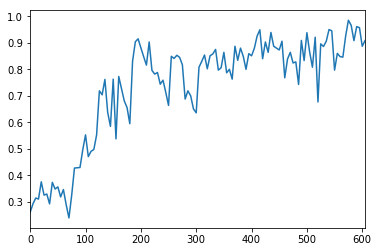

In [127]:
tmp = pd.Series(resPerc).reset_index(drop = True)
tmp.index = tmp.index*5
(tmp/1000.).plot()

In [124]:
%matplotlib inline

In [111]:
#cp.initialize_from('/tmp/es_master_2148/snapshot_iter00325_rew444.h5')
#cp.initialize_from('/tmp/es_master_2148/snapshot_iter00370_rew426.h5')
cp.initialize_from('/tmp/es_master_2148/snapshot_iter00435_rew507.h5') #94 %
#cp.initialize_from('/tmp/es_master_2148/snapshot_iter01125_rew544.h5')

In [112]:

cp.rollout(env)



(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,  1000.], dtype=float32),
 8)

In [113]:
tmp = [cp.rollout(env)[0][-1] for i in range(1000)]
np.mean(tmp)

975.5

In [114]:
tmp = [cp.rollout(env)[0][-1] for i in range(1000)]
np.mean(tmp)

979.5

In [115]:
import pandas as pd
tmpSer = pd.Series(tmp)
tmpSer[tmpSer>0].shape

(938,)

tmp = [cp.rollout(env)[0][-1] for i in range(100)]
tmp

In [35]:

cp.rollout(env)



(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,  1000.], dtype=float32),
 8)

In [ ]:
    def step(self, ac):
        return self.ep.send(ac)

    def reset(self):
        self.ep = episode()
        S, won, _, _ = self.ep.__next__()

In [2]:
def episodeSampling():
    """
    Coroutine of episode.

    Action has to be explicitly send to this coroutine.
    """
    x, y, z = (
        np.random.randint(0, GRID_SIZE),  # X of fruit
        0,  # Y of dot
        np.random.randint(1, GRID_SIZE - 1)  # X of basket
    )
    while True:
        X = np.zeros((GRID_SIZE, GRID_SIZE))  # Reset grid
        X[y, x] = 1.  # Draw fruit
        bar = range(z - 1, z + 2)
        X[-1, bar] = 1.  # Draw basket

        # End of game is known when fruit is at penultimate line of grid.
        # End represents either a win or a loss
        end = int(y >= GRID_SIZE - 2)
        rew = 0
        if end and x in bar:
            rew = 1000
        if end and x not in bar:
            rew = -1000
        if end and x == bar[1]:
            rew = 1500

        
        action = yield X.ravel(), rew, end, (x,  y, z)

        move = action

        #assert action in [0, 1, 2]
        if end:
            break

        z = np.min([np.max([z + move - 1, 1]), GRID_SIZE - 2])
        y += 1


In [3]:
import pickle

In [13]:

memory = []
for i in range(5):
    ep = episodeSampling()
    episodList = []

    Xprev, won, end, (x, y,z) = ep.__next__()
    
    goodEx = np.random.randint(2)
    goodEx = 1
    while not end:
        
        action = np.sign(x -z) + 1
        if not goodEx:
            action =np.sign(z - x) + 1 
        
        if action  == 0:
           acDistr = np.array([.75, 0.15,.10 ]) 
        if action  == 1:
           acDistr = np.array([.33, 0.33,.33 ]) 
        if action  == 2:
           acDistr = np.array([.1, 0.15,.75 ]) 
        
        if x == z:
            acDistr = np.array([.33]*3)
            action = np.random.randint(3)
        #print(z, x,z-x, action)
        print(Xprev.reshape((10, 10)))
        if action not in [0, 1, 2]:
            print (action)
        X, rew, end, (x, y,z) = ep.send(action)
        
        
        episodList.append((Xprev, action, rew, acDistr))
        Xprev = X
        
        if end:
            print(rew)
    memory.append(episodList)

[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.  1.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  1.  1.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.

 [ 0.  0.  0.  0.  0.  1.  1.  1.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  1.  1.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  1.  1.  0.  0.]]
1000
[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 

In [28]:
pickle.dump(memory,open('memoryList.pickle', 'wb'))

In [72]:
np.random.randint(2)

0

In [ ]:
ob, rew, done, _ = env.step(ac)
ob = env.reset()

In [9]:
x

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])